In [2]:
print("Size: %d" %df.shape[0])
df.head()

Size: 27991302


,flair_text,body,subreddit,author
0,INFP: The Dreamer Senpai,Lol that's why I left.,entp,LadyBanterbury
1,INTP: The Theorist,"I was just about to post ""I try telling people...",INTP,Finarin
2,INFP: The Dreamer,My first thought was Pepsi or something. Proba...,WTF,xanplease
3,"ENTP: Antisocial Extrovert, Rational Eccentric","Not if the formula is something like ""every ti...",youtubehaiku,HeirToGallifrey
4,INTP/18/m/blankly staring at you,Does this imply I'm a five now?,entp,lightfive


Wow! 27.99 million cases! Let's see how much of that's going to go away. Fix flair text so that we have just the MBTI code. Every single flair_text has been filtered on BigQuery for MBTI so no need to filter out irrelevant posts but will return NaN just in case (legacy from prior attempt at this problem). 

In [3]:
mbtiValues = ["ESTJ", "ESTP", "ESFP", "ESFJ", "ISTJ", "ISTP", "ISFP", "ISFJ", "INTJ", "INTP", "INFP",
              "INFJ", "ENTJ", "ENTP", "ENFP", "ENFJ"]

def filterMBTIandUpper(text, mbtiList):
    for mbti in mbtiList:
        if mbti in text.upper():
            return mbti
    
    return "NaN"

df["flair_text"] = df["flair_text"].apply(lambda x: filterMBTIandUpper(x, mbtiValues))
df.head(10)

,flair_text,body,subreddit,author
0,INFP,Lol that's why I left.,entp,LadyBanterbury
1,INTP,"I was just about to post ""I try telling people...",INTP,Finarin
2,INFP,My first thought was Pepsi or something. Proba...,WTF,xanplease
3,ENTP,"Not if the formula is something like ""every ti...",youtubehaiku,HeirToGallifrey
4,INTP,Does this imply I'm a five now?,entp,lightfive
5,INTP,"Well, I wouldn't know but I think there's a lo...",InternetIsBeautiful,ElementalVoltage
6,INFJ,"sine na, support the directors, actors and oth...",Philippines,BabyFlo70
7,INTP,I use just enough vacation days so that I don'...,tumblr,RockinSocksReborn
8,INTP,Can be ur angle... or you're devil ;),woof_irl,crowbird_
9,INTP,I mean we don't how much influence Crow has on...,RWBY,RockinSocksReborn


Let's quantify the most/least represented subreddits (Top/Bottom 20 for each) and then drop both the author and subreddits afterwards since they're no longer relevant beyond getting a feel for where this data is being pulled from. 

In [4]:
subreddit = df["subreddit"].value_counts()

print("Most Represented Subreddits:")
print(subreddit[0:20])

print("Least Represented Subreddits:")
print(subreddit[-20:])

df = df.drop(columns=["subreddit", "author"])
df.head(10)

Most Represented Subreddits:
subreddit
AskReddit          2380826
entp               1037801
mbti                789610
INTP                643073
infj                511681
infp                390621
politics            304462
intj                280954
funny               273608
pics                240884
AskWomen            236714
teenagers           232888
todayilearned       200796
leagueoflegends     189185
worldnews           176277
france              169052
gaming              162965
AdviceAnimals       159194
anime               158722
Christianity        158648
Name: count, dtype: int64
Least Represented Subreddits:
subreddit
DissonautUniverse    1
amino                1
legostarwarsmemes    1
catsridingroombas    1
BlacksOnAsians       1
vagabonding          1
CosaNostra           1
treees               1
IRCrpg               1
PussySlip            1
healthcareIT         1
ThePoetryofCinema    1
Alt_Hapa             1
zenjerk              1
CircleOfLove         1
The_Italia

,flair_text,body
0,INFP,Lol that's why I left.
1,INTP,"I was just about to post ""I try telling people..."
2,INFP,My first thought was Pepsi or something. Proba...
3,ENTP,"Not if the formula is something like ""every ti..."
4,INTP,Does this imply I'm a five now?
5,INTP,"Well, I wouldn't know but I think there's a lo..."
6,INFJ,"sine na, support the directors, actors and oth..."
7,INTP,I use just enough vacation days so that I don'...
8,INTP,Can be ur angle... or you're devil ;)
9,INTP,I mean we don't how much influence Crow has on...


Now let's see what's going on with class imbalance. I know from simply perusing through some of the MBTI subreddits that the INXX are the most represented on Reddit. Let's see how bad it is. 

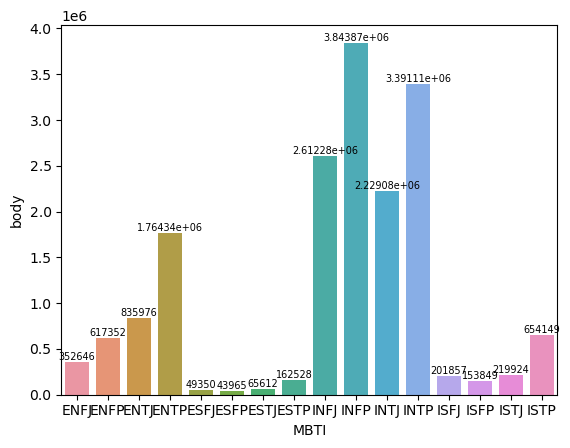

In [5]:
uniquesByMBTI = df.groupby("flair_text").nunique()

uniquesByMBTI.index.name = 'MBTI'
uniquesByMBTI.reset_index(inplace=True)
ax = sns.barplot(x="MBTI", y="body", data=uniquesByMBTI)
ax.bar_label(ax.containers[0], fontsize=7)
plt.show()

Okay, wow. That's a ridiculous class imbalance. ESFP only has 43,965 examples while the INXX categories are averaging about ~2.8 million. There's no upsampling for this. However, downsamples across the board should make this fine. Before we do this, however, let's make sure we aren't accidentally downsampling things that would've been filtered out otherwise. We can do this by cleaning the whole set first. 

In [6]:
def firstPassClean(x):
    # Cleans: URLs, non-ASCII, HTML
    x = str(x)
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'http*\S+', ' ', x)
    x = x.encode('ascii', 'ignore').decode()
    x = html.unescape(x)
    x = re.sub("\n", ' ', x)
    x = re.sub(r"[\[\]]", '', x)
    return x

In [7]:
import swifter

df["cleaned"] = df.body.swifter.apply(firstPassClean)
df = df[~df["cleaned"].eq('')].dropna()

Pandas Apply:   0%|          | 0/27991302 [00:00<?, ?it/s]

In [8]:
import fasttext

model = fasttext.load_model("model.bin")

def removeNonEnglish(text, model):
    prediction = model.predict(text)
    if prediction[0][0] == "__label__eng_Latn":
        return text
    else:
        return "NaN"

In [9]:
df["cleaned"] = df["cleaned"].swifter.apply(lambda x: removeNonEnglish(x, model))

Pandas Apply:   0%|          | 0/27978554 [00:00<?, ?it/s]

Now let's get rid of all the text that might've been filtered out by this. 

In [10]:
df = df[df["cleaned"].str.contains("NaN") == False]
print("Size: %d" %df.shape[0])

Size: 26117823


Surprisingly not many samples have been removed. Let's save this file as csv and then move onto some more advanced filtering. 

In [11]:
df.to_csv("cleaned_dataframe.csv")

In [16]:
# Artifact from the regex expression used to remove links. So the only thing to check for is "(" unpaired with its 
# corresponding ")". If there is an unbalanced parenthesis, it returns True. else, returns False. 
def checkUnbalancedParens(x):
    check = x.find("(")
    if check != -1:
        if x.find(")") != -1:
            return False
        elif x.find(")") == -1 and (x[check-1] != ":" and x[check-1] != "'"):
            return True
    else:
        return False

def SecondPassClean(x):
    x = x.strip()
    if checkUnbalancedParens(x):
        x = x.replace("(", "")
    x = re.sub(r'\s{2,}', ' ', x) # Remove extra spaces
    x = re.sub(r'\s[^\w\s]\s', ' ', x) # Remove extra white space between words
    if len(x) <= 6: # It's too short to qualify
        return ''
    
    return x

In [18]:
df["cleaned"] = df.cleaned.swifter.apply(SecondPassClean)

Pandas Apply:   0%|          | 0/26117823 [00:00<?, ?it/s]

In [20]:
df = df[~df["cleaned"].eq('')].dropna()
print("Size: %d" %df.shape[0])

Size: 25790335


Surprisingly not many have been filtered out. Let's save this and then downsample. As we know, the ESFP and ESFJ categories are the least represented. Need to downsample the rest of the categories to about ~50,000 samples per category. But to ensure that there's a decently similar set of distributions, let's add a column for string length.

In [21]:
df["body length"] = df.cleaned.swifter.apply(len)

Pandas Apply:   0%|          | 0/25790335 [00:00<?, ?it/s]

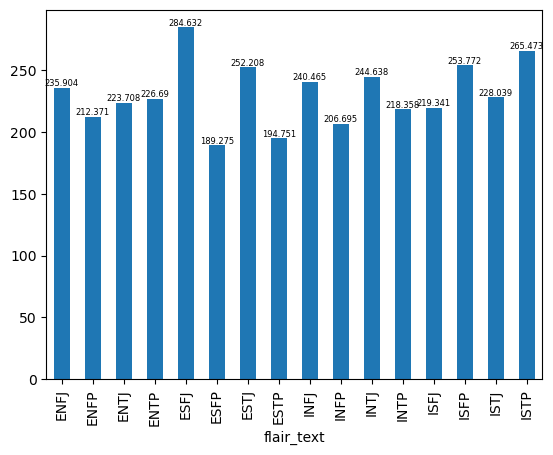

In [28]:
avgLen = df.groupby('flair_text')["body length"].mean()
ax = avgLen.plot.bar()
ax.bar_label(ax.containers[0], fontsize=6)
plt.show() 

Surprisingly balanced on the character length! Now let's check the variance. 

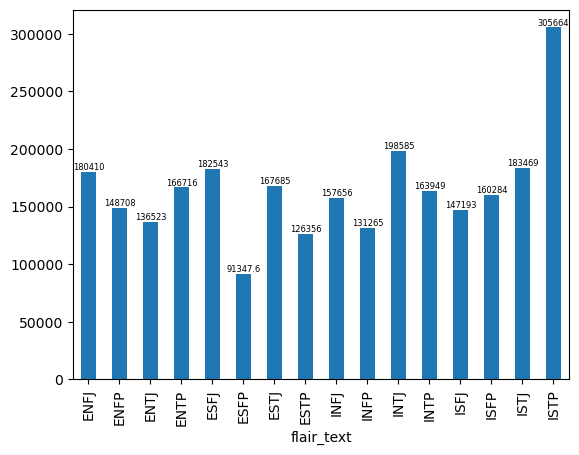

In [30]:
varLen = df.groupby('flair_text')["body length"].var()
ax = varLen.plot.bar()
ax.bar_label(ax.containers[0], fontsize=6)
plt.show() 

Variance is a little more skewed, especially for ISTP. However, this could provide some insight. Let's do our downsampling now.

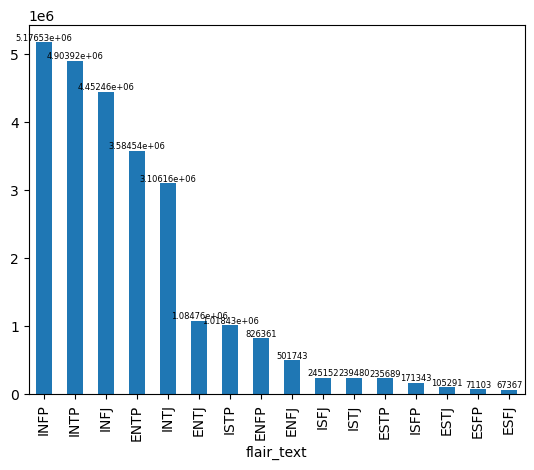

In [33]:
mbtiSizes = df["flair_text"].value_counts()
ax = mbtiSizes.plot.bar()
ax.bar_label(ax.containers[0], fontsize=6)
plt.show() 

In [36]:
from sklearn.utils import resample
df = df.drop(columns=["body length"])
finalArr = []
finalSizePerCat = 70000
for mbti in mbtiValues:
    if mbtiSizes[mbti] <= finalSizePerCat:
        finalArr.append(df[df["flair_text"] == mbti])
    else:
        finalArr.append(resample(df[df["flair_text"] == mbti], replace=False, n_samples=finalSizePerCat))

finalDf = pd.concat(finalArr)

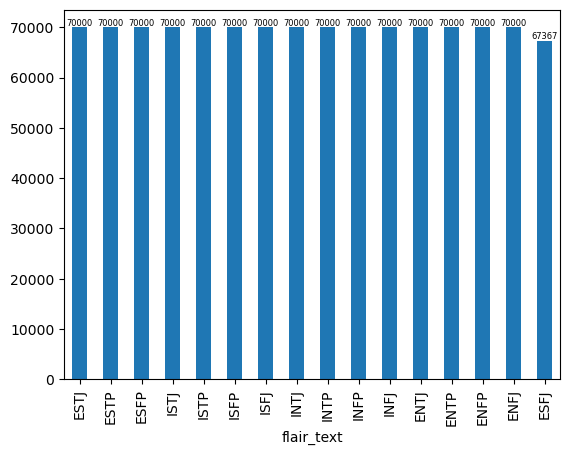

In [37]:
mbtiSizesf = finalDf["flair_text"].value_counts()
ax = mbtiSizesf.plot.bar()
ax.bar_label(ax.containers[0], fontsize=6)
plt.show() 

In [40]:
# finalDf = finalDf.drop(columns=["body", "body length"])
finalDf = finalDf.drop(columns=["body"])
finalDf.to_csv("downsampledTrainSet.csv", index=False)
df.to_csv("rawTrainSet.csv", index=False)